# GBM Simulation for Stocks

## Project Summary

This project simulates **Geometric Brownian Motion (GBM)** to model and forecast future stock prices for top technology tickers. It combines:
- **Quantitative finance mathematics** (GBM stochastic differential equations)
- **Data science** (log returns, drift, volatility estimation)
- **Real market data** from Yahoo Finance

I aim to understand both the **stochastic components (Brownian motion increments)** and the **drift component** that drive daily returns, then use these to simulate future prices over both long-term (quarterly horizon) and intraday (hourly interval).

### Mathematical Background

#### Geometric Brownian Motion (GBM)
The stock price under GBM evolves according to:

$$
dS_t = \mu S_t dt + \sigma S_t dB_t
$$

where:
- $\mu$ is the **drift** (expected return)  
- $\sigma$ is the **volatility** (standard deviation of returns)  
- $B_t$ is a **standard Brownian motion**

The discretized solution is:

$$
S_t = S_0 \exp \left[ (\mu - \frac{1}{2}\sigma^2)t + \sigma B_t \right]
$$


#### Stochastic Differential Equation (SDE)
The GBM SDE indicates that the instantaneous change in the stock price $dS_t$ is composed of a **deterministic trend** ($\mu S_t dt$) and a **random shock** ($\sigma S_t dB_t$), which defined is:

$$
dS_t = \mu S_t dt + \sigma S_t dB_t
$$

where:
- $dB_t$ is an increment of a **standard Brownian motion**, representing the stochastic (random) component.


#### Log Return Distribution under GBM
Under GBM assumptions, the **log return** over time horizon $t$ is normally distributed:

$$
r_t = \log S_t \sim \mathcal{N} \left( \log S_0 + \left( \mu - \frac{1}{2} \sigma^2 \right)t , \sigma^2 t \right)
$$

or equivalently,

$$
\log \left( \frac{S_t}{S_0} \right) \sim \mathcal{N} \left( \left( \mu - \frac{1}{2} \sigma^2 \right)t , \sigma^2 t \right)
$$

where:

- $r_t$ is the **log price at time $t$**  
- The mean is adjusted by $\left( \mu - \frac{1}{2} \sigma^2 \right)t$ due to **Ito’s lemma correction** (accounting for volatility drag)
- The variance grows linearly with time: $\sigma^2 t$


#### Interpretation

- **GBM (Geometric Brownian Motion)** is a continuous-time stochastic process used to model stock prices, assuming proportional random changes and lognormal distribution of prices. 
- **SDE** captures the continuous-time dynamics of stock prices, combining trend and randomness.  
- **Log Return Distribution** is useful for deriving option pricing models (e.g. Black-Scholes) and simulating future prices via Monte Carlo.  
- **Volatility drag adjustment ($-\frac{1}{2}\sigma^2$)** reflects the fact that geometric returns are lognormally distributed, and higher volatility reduces expected geometric growth rate.


### Code Workflow

1. **Download** 1-year daily close prices from Yahoo Finance using `yfinance`.
2. **Calculate daily log returns** to derive the mean (drift) and standard deviation (volatility).
3. **Annualize** drift and volatility to fit the GBM parameters.
4. **Generate Brownian motion increments and path**:
   - `brownian_increments = np.random.normal(0, sqrt(dt), N)`
   - `brownian_path = np.concatenate([0], np.cumsum(brownian_increments))`
5. **Compute GBM path** over the selected time window (T).
6. **Plot simulated GBM paths** for selected tickers under two modes:
   - Quarterly (63 trading days) – for long-term trend analysis
   - Hourly (7 hours within a trading day) – for intraday price simulation

### Key Observations

- **Brownian increments** determine the random shocks (stochastic component) of daily returns.  
- **Brownian path** accumulates these shocks, visualizing the deviation from the deterministic drift.  
- The final GBM path combines drift + stochastic components to model potential future prices.

### Sample Outputs

1. **First 5 Brownian increments** printed for insight into daily random shocks  
2. **Final Brownian path value** printed for cumulative random impact

### GBM Simulation Plots

Below are the GBM simulation results for **QQQ and its top 5 constituents** (MSFT, AAPL, META, GOOGL, TSLA):
   - Quarterly mode: Simulates stock prices over ~63 trading days
   - Hourly mode: Simulates price movements within the next trading day (7 × 30-min steps)

### Simulation Modes

This project supports two modes of simulation:
   - Quarterly: simulates long-term evolution of stock prices over a 3-month horizon
   - Hourly: simulates intraday price movements across 7 half-hour intervals, useful for short-term trading strategies




In [53]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

def simulate_hourly_gbm(ticker_symbol):
    # Load past 60 days hourly stock prices
    stock = yf.download(ticker_symbol, period="60d", interval="30m", progress=False)

    # Stop simulation when not enough hourly data
    if stock.empty or len(stock) < 2:
        print(f"Warning: Not enough hourly data for {ticker_symbol} to simulate")
        return None, None, None
    
    # Calculate hourly log returns
    stock['LogReturn'] = np.log(stock['Close'] / stock['Close'].shift(1))
    stock = stock.dropna()

    # Calculate daylized drift(mu) and volatility(sigma)
    hours_per_hour = 24      # 24 hours per day
    mu = stock['LogReturn'].mean() * hours_per_hour
    sigma = stock['LogReturn'].std() * np.sqrt(hours_per_hour)

    # Initialize GBM parameters
    S0 = stock['Close'].iloc[-1].item()
    T = 1
    N = hours_per_hour
    dt = T / N

    # Generate Brownian motion increments and path
    brownian_increments = np.random.normal(0, np.sqrt(dt), N)
    brownian_path = np.concatenate(([0], np.cumsum(brownian_increments)))
    time_grid = np.linspace(0, T, N + 1)
    
    gbm_path = S0 * np.exp((mu - 0.5 * sigma**2) * time_grid + sigma * brownian_path)
    
    print(f"{ticker_symbol} GBM path (last value): {gbm_path[-1]}") 
    return time_grid, gbm_path, S0

def plot_hourly_gbm_simulations():
    # Define the list of tickers to analyze
    tickers_to_plot = ["QQQ", "TSLA", "PLTR", "IONQ", "RKLB", "UBER"]
    print(f"Target tickers for analysis: {tickers_to_plot}")

    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    fig.suptitle('Hourly GBM Simulation for Next Trading Day', fontsize=16)
    axes = axes.flatten()

    for i, ticker_symbol in enumerate(tickers_to_plot):
        ax = axes[i]

        time_grid, gbm_path, S0 = simulate_hourly_gbm(ticker_symbol)

        if gbm_path is not None:
            ax.plot(time_grid, gbm_path, label='Simulated Path')
            ax.axhline(y=S0, color='r', linestyle='--', label=f'Start Price: ${S0:.2f}')
            
            ax.set_title(f'Hourly Simulation for {ticker_symbol}')
            ax.set_xlabel("Trading Hour of the Day")
            ax.set_ylabel("Stock Price")
            ax.grid(True)
            ax.legend()
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

Target tickers for analysis: ['QQQ', 'TSLA', 'PLTR', 'IONQ', 'RKLB', 'UBER']


/var/folders/fm/l2mt68311m371d9mhqxp3fq00000gn/T/ipykernel_78288/665839001.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock = yf.download(ticker_symbol, period="60d", interval="30m", progress=False)


QQQ GBM path (last value): 559.3102425373037


/var/folders/fm/l2mt68311m371d9mhqxp3fq00000gn/T/ipykernel_78288/665839001.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock = yf.download(ticker_symbol, period="60d", interval="30m", progress=False)


TSLA GBM path (last value): 335.14378285415233


/var/folders/fm/l2mt68311m371d9mhqxp3fq00000gn/T/ipykernel_78288/665839001.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock = yf.download(ticker_symbol, period="60d", interval="30m", progress=False)


PLTR GBM path (last value): 149.79811593946712


/var/folders/fm/l2mt68311m371d9mhqxp3fq00000gn/T/ipykernel_78288/665839001.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock = yf.download(ticker_symbol, period="60d", interval="30m", progress=False)


IONQ GBM path (last value): 43.17054012695395


/var/folders/fm/l2mt68311m371d9mhqxp3fq00000gn/T/ipykernel_78288/665839001.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock = yf.download(ticker_symbol, period="60d", interval="30m", progress=False)


RKLB GBM path (last value): 48.09828773716591


/var/folders/fm/l2mt68311m371d9mhqxp3fq00000gn/T/ipykernel_78288/665839001.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock = yf.download(ticker_symbol, period="60d", interval="30m", progress=False)


UBER GBM path (last value): 92.12245035481334


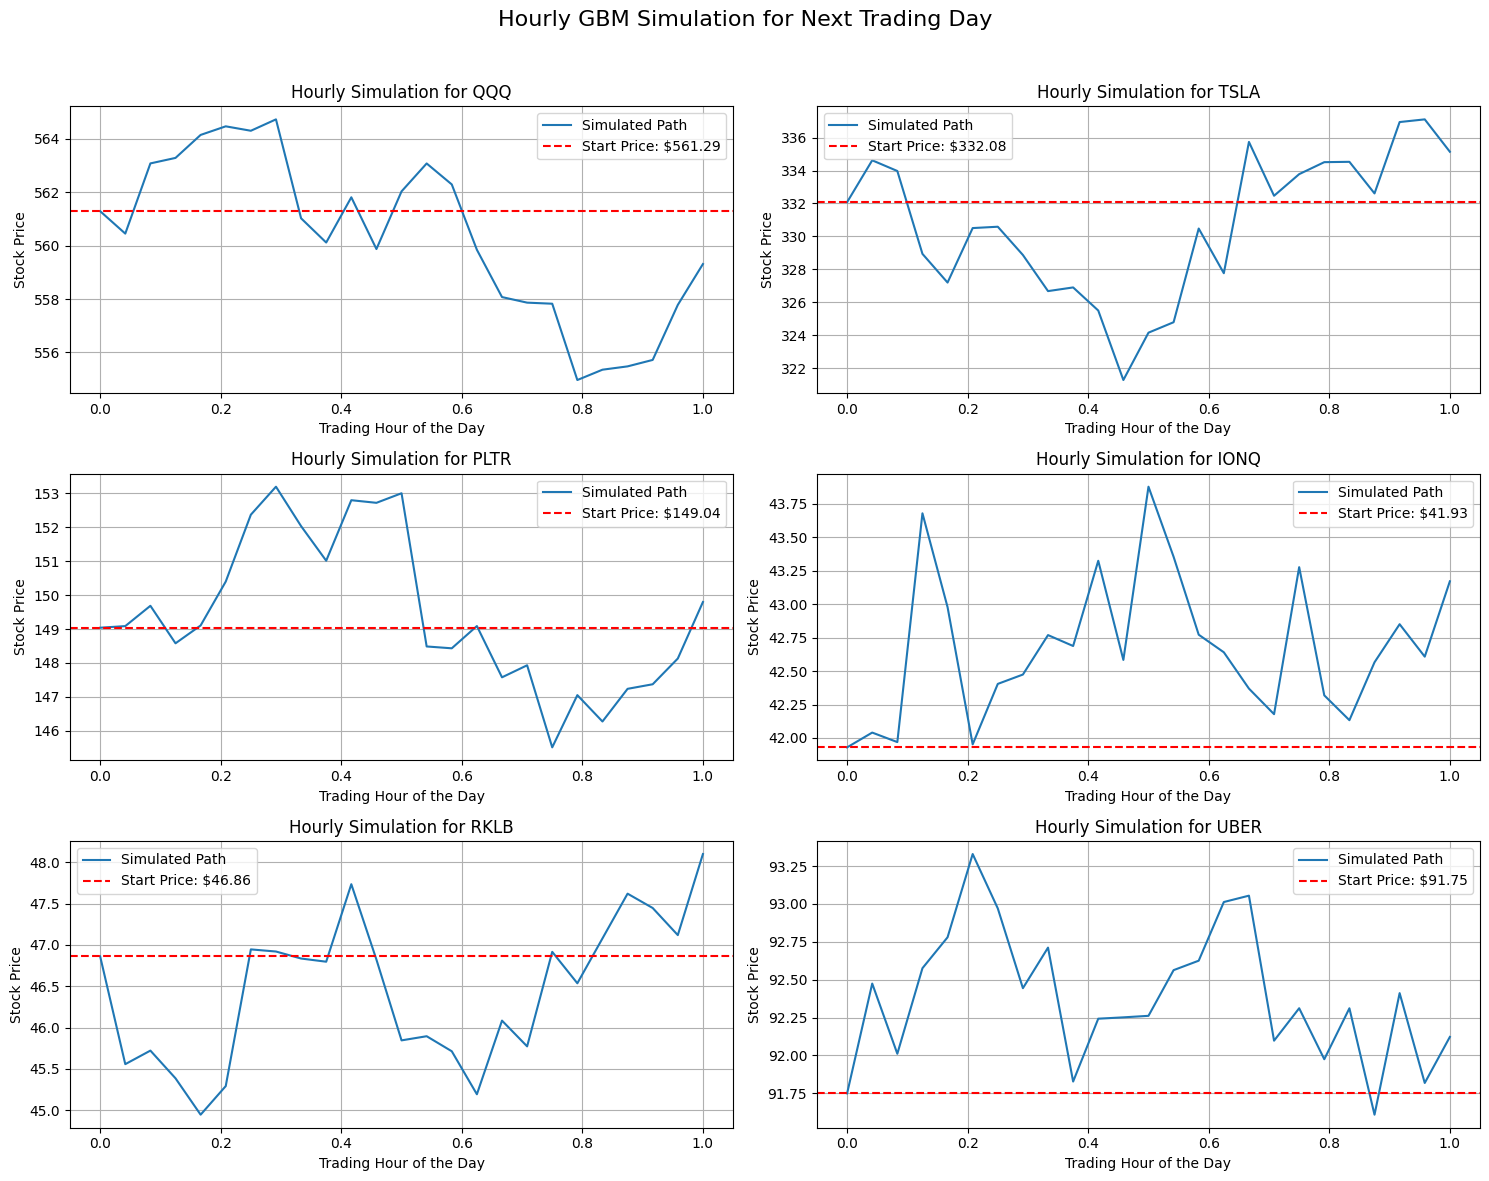

In [54]:
plot_hourly_gbm_simulations()

In [ ]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

def simulate_gbm(ticker_symbol, mode='quarterly'):
    # Set parameters according to mode
    if mode == 'quarterly':
        params = {
            'period': '1y',
            'interval': '1d',
            'scaling_factor': 252,  # Trading days per year
            'T': 0.25,              # 0.25 years (1 quarter)
            'N': 63,                # 63 trading days
            'xlabel': 'Trading Day'
        }
    elif mode == 'hourly':
        params = {
            'period': '60d',
            'interval': '30m',
            'scaling_factor': 24,   # 24 trading hours per day
            'T': 1,                 # 1 day
            'N': 7,                 # 7 trading hours
            'xlabel': 'Trading Hour of the Day'
        }
    else:
        raise ValueError("Invalid mode. Choose 'quarterly' or 'hourly'.")

    # Download market data
    stock = yf.download(ticker_symbol, period=params['period'], interval=params['interval'], progress=False)
    
    if stock.empty or len(stock) < 2:
        print(f"Warning: Not enough {mode} data for {ticker_symbol} to simulate.")
        return None

    # Calculate log returns and compute parameters
    stock['LogReturn'] = np.log(stock['Close'] / stock['Close'].shift(1))
    stock = stock.dropna()
    
    mu = stock['LogReturn'].mean() * params['scaling_factor']
    sigma = stock['LogReturn'].std() * np.sqrt(params['scaling_factor'])
    S0 = stock['Close'].iloc[-1].item()
    dt = params['T'] / params['N']

    # Compute GBM path (vectorized method)
    brownian_increments = np.random.normal(0, np.sqrt(dt), params['N'])
    brownian_path = np.concatenate([0], np.cumsum(brownian_increments))
    time_grid = np.linspace(0, params['T'], params['N'] + 1)
    gbm_path = S0 * np.exp((mu - 0.5 * sigma**2) * time_grid + sigma * brownian_path)
    
    # Grid for x-axis (for display in trading days or hours)
    display_grid = np.arange(params['N'] + 1)
    
    return {
        'grid': display_grid,
        'path': gbm_path,
        's0': S0,
        'xlabel': params['xlabel'],
        'title': f'{mode.capitalize()} Simulation for {ticker_symbol}'
    }


def rank_stocks_by_gbm(tickers, mode='quarterly'):
    results_list = []

    for ticker in tickers:
        results = simulate_gbm(ticker, mode=mode)
        
        if results:
            gbm_path = results['path']
            s0 = results['s0']
            
            # Calculate the average value of the simulated GBM path
            path_avg = np.mean(gbm_path)
            
            # Compute a normalized score (expected average return)
            normalized_score = (path_avg - s0) / s0
            
            results_list.append({'ticker': ticker, 'score': normalized_score})

    # Sort the list by score in descending order
    sorted_results = sorted(results_list, key=lambda x: x['score'], reverse=True)

    # Print ranking results
    print("\nRanking stocks based on {mode} GBM simulation: ")
    for i, result in enumerate(sorted_results):
        print(f"Rank {i+1}: {result['ticker']:<6} | Score: {result['score']:.4f}")
    
    return sorted_results


def plot_gbm_simulations(tickers, mode='quarterly'):
    print(f"Target tickers for {mode} analysis: {tickers}")

    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    main_title = 'Hourly GBM Simulation for Next Trading Day' if mode == 'hourly' else 'GBM Simulation for Next Quarter'
    fig.suptitle(main_title, fontsize=16)
    axes = axes.flatten()

    for i, ticker_symbol in enumerate(tickers):
        ax = axes[i]
        
        results = simulate_gbm(ticker_symbol, mode=mode)
        
        if results:
            ax.plot(results['grid'], results['path'], label='Simulated Path')
            ax.axhline(y=results['s0'], color='r', linestyle='--', label=f"Start Price: ${results['s0']:.2f}")
            ax.set_title(results['title'])
            ax.set_xlabel(results['xlabel'])
            ax.set_ylabel("Stock Price")
            ax.grid(True)
            ax.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

/var/folders/fm/l2mt68311m371d9mhqxp3fq00000gn/T/ipykernel_78288/3142243584.py:29: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock = yf.download(ticker_symbol, period=params['period'], interval=params['interval'], progress=False)
/var/folders/fm/l2mt68311m371d9mhqxp3fq00000gn/T/ipykernel_78288/3142243584.py:29: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock = yf.download(ticker_symbol, period=params['period'], interval=params['interval'], progress=False)
/var/folders/fm/l2mt68311m371d9mhqxp3fq00000gn/T/ipykernel_78288/3142243584.py:29: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock = yf.download(ticker_symbol, period=params['period'], interval=params['interval'], progress=False)
/var/folders/fm/l2mt68311m371d9mhqxp3fq00000gn/T/ipykernel_78288/3142243584.py:29: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock = yf.download(ticker_symbol


Ranking stocks based on {mode} GBM simulation: 
Rank 1: TSLA   | Score: 0.2553
Rank 2: AAPL   | Score: 0.1837
Rank 3: MSFT   | Score: 0.1525
Rank 4: META   | Score: 0.0734
Rank 5: GOOGL  | Score: 0.0210
Rank 6: QQQ    | Score: -0.0615
Target tickers for quarterly analysis: ['QQQ', 'TSLA', 'MSFT', 'AAPL', 'META', 'GOOGL']


/var/folders/fm/l2mt68311m371d9mhqxp3fq00000gn/T/ipykernel_78288/3142243584.py:29: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock = yf.download(ticker_symbol, period=params['period'], interval=params['interval'], progress=False)
/var/folders/fm/l2mt68311m371d9mhqxp3fq00000gn/T/ipykernel_78288/3142243584.py:29: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock = yf.download(ticker_symbol, period=params['period'], interval=params['interval'], progress=False)
/var/folders/fm/l2mt68311m371d9mhqxp3fq00000gn/T/ipykernel_78288/3142243584.py:29: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock = yf.download(ticker_symbol, period=params['period'], interval=params['interval'], progress=False)
/var/folders/fm/l2mt68311m371d9mhqxp3fq00000gn/T/ipykernel_78288/3142243584.py:29: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock = yf.download(ticker_symbol

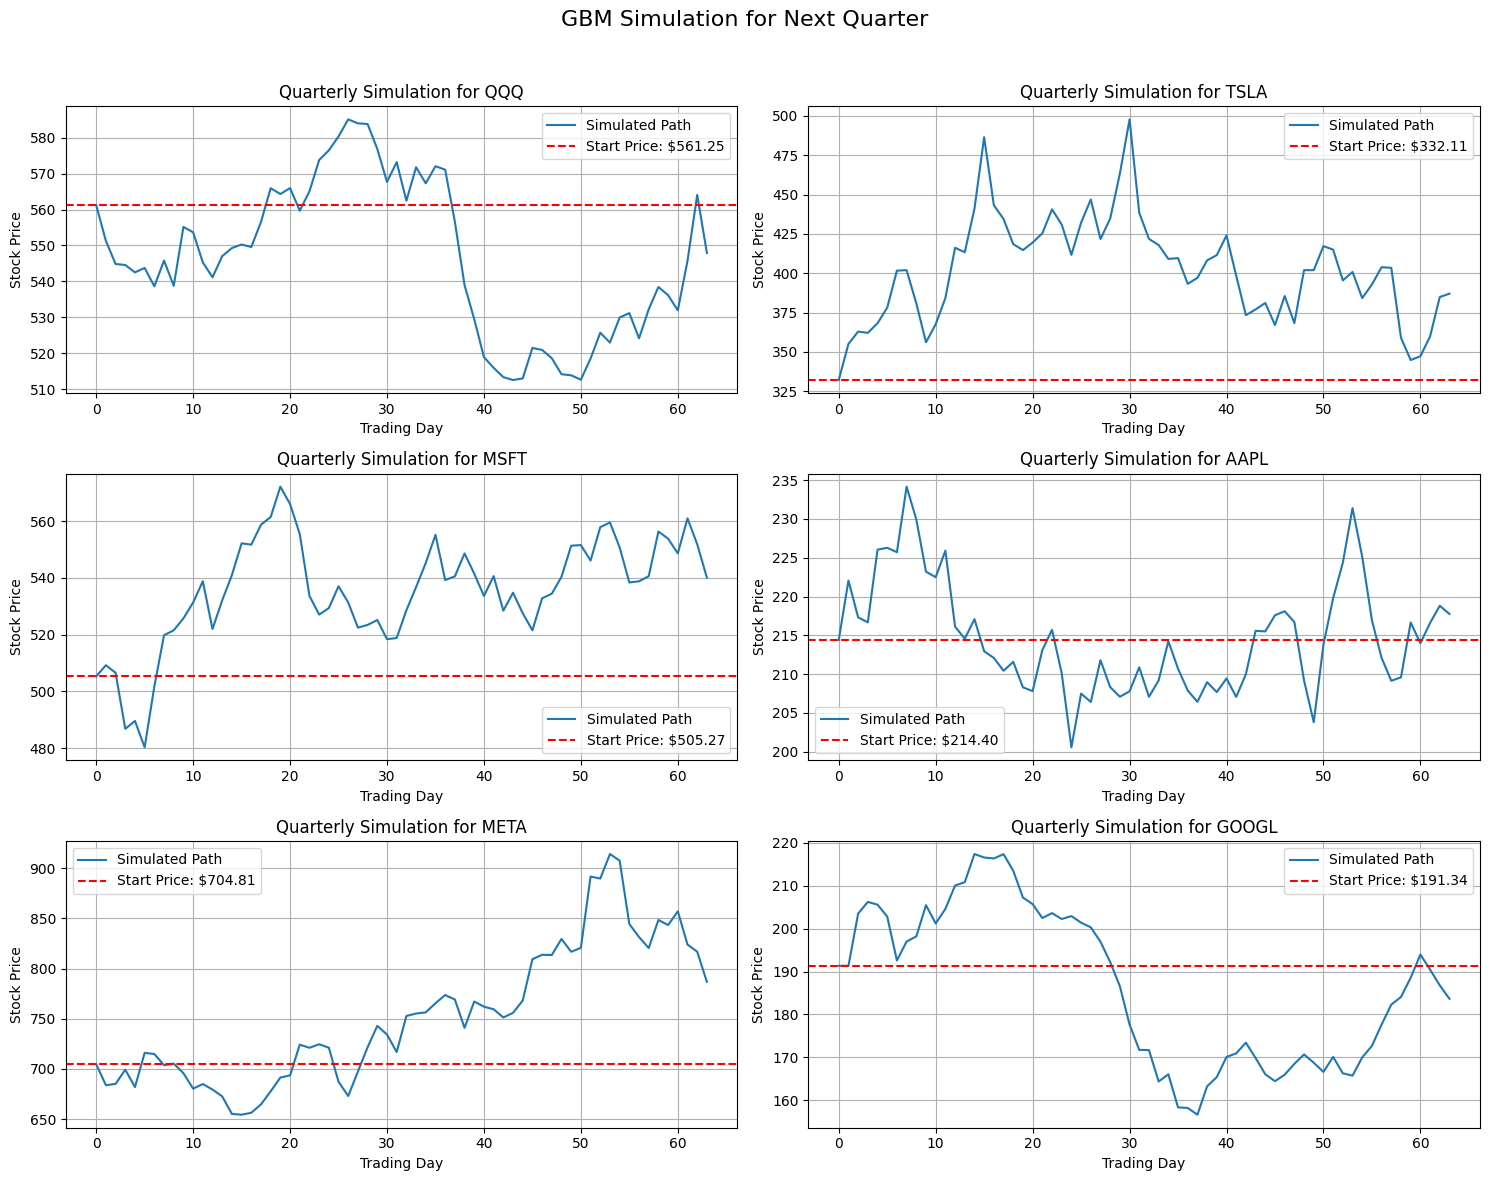

In [51]:
if __name__ == '__main__':
    tickers_to_plot = ["QQQ", "TSLA", "MSFT", "AAPL", "META", "GOOGL"]
    ranked_stocks = rank_stocks_by_gbm(tickers_to_plot, mode='quarterly')

    plot_gbm_simulations(tickers_to_plot, mode='quarterly')    

/var/folders/fm/l2mt68311m371d9mhqxp3fq00000gn/T/ipykernel_78288/3142243584.py:29: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock = yf.download(ticker_symbol, period=params['period'], interval=params['interval'], progress=False)
/var/folders/fm/l2mt68311m371d9mhqxp3fq00000gn/T/ipykernel_78288/3142243584.py:29: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock = yf.download(ticker_symbol, period=params['period'], interval=params['interval'], progress=False)
/var/folders/fm/l2mt68311m371d9mhqxp3fq00000gn/T/ipykernel_78288/3142243584.py:29: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock = yf.download(ticker_symbol, period=params['period'], interval=params['interval'], progress=False)
/var/folders/fm/l2mt68311m371d9mhqxp3fq00000gn/T/ipykernel_78288/3142243584.py:29: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock = yf.download(ticker_symbol


Ranking stocks based on {mode} GBM simulation: 
Rank 1: TSLA   | Score: 0.0287
Rank 2: META   | Score: 0.0166
Rank 3: GOOGL  | Score: 0.0018
Rank 4: QQQ    | Score: 0.0004
Rank 5: MSFT   | Score: -0.0051
Rank 6: AAPL   | Score: -0.0107
Target tickers for hourly analysis: ['QQQ', 'TSLA', 'MSFT', 'AAPL', 'META', 'GOOGL']


/var/folders/fm/l2mt68311m371d9mhqxp3fq00000gn/T/ipykernel_78288/3142243584.py:29: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock = yf.download(ticker_symbol, period=params['period'], interval=params['interval'], progress=False)
/var/folders/fm/l2mt68311m371d9mhqxp3fq00000gn/T/ipykernel_78288/3142243584.py:29: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock = yf.download(ticker_symbol, period=params['period'], interval=params['interval'], progress=False)
/var/folders/fm/l2mt68311m371d9mhqxp3fq00000gn/T/ipykernel_78288/3142243584.py:29: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock = yf.download(ticker_symbol, period=params['period'], interval=params['interval'], progress=False)
/var/folders/fm/l2mt68311m371d9mhqxp3fq00000gn/T/ipykernel_78288/3142243584.py:29: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock = yf.download(ticker_symbol

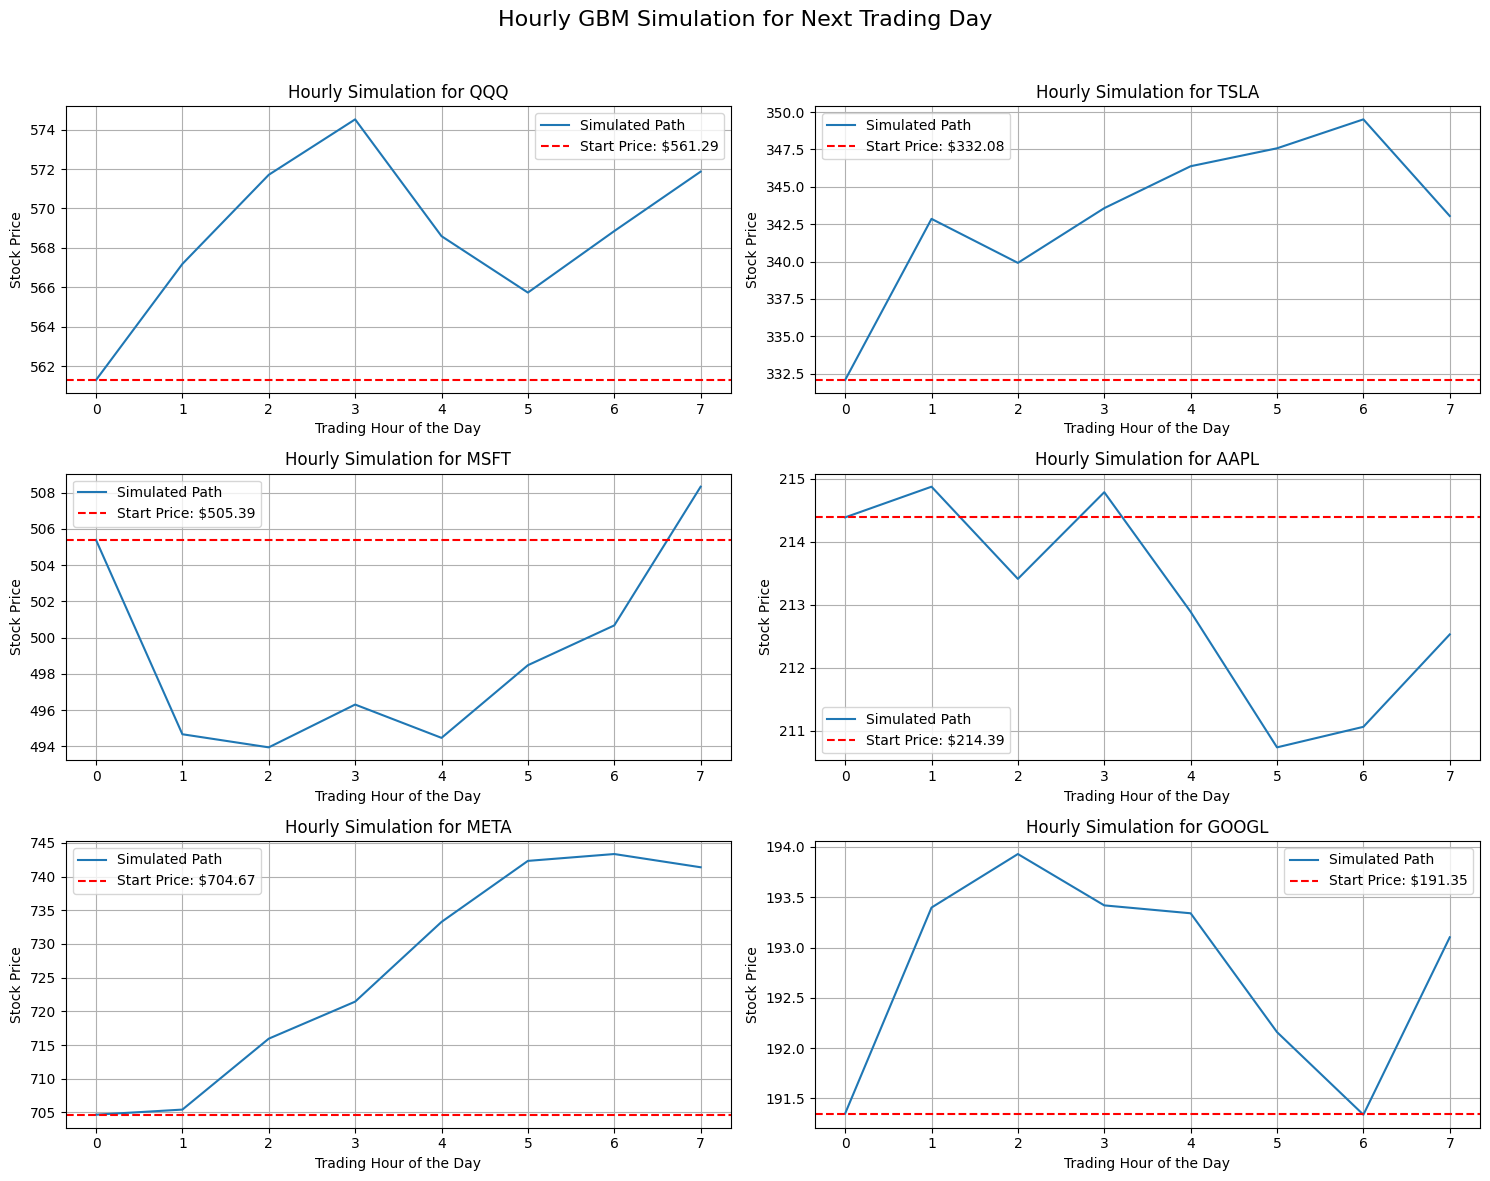

In [52]:
if __name__ == '__main__':
    tickers_to_plot = ["QQQ", "TSLA", "MSFT", "AAPL", "META", "GOOGL"]
    ranked_stocks = rank_stocks_by_gbm(tickers_to_plot, mode='hourly')

    plot_gbm_simulations(tickers_to_plot, mode='hourly')

### Code Workflow

1. **Download** 1-year daily close prices from Yahoo Finance using `yfinance` for each ticker.
2. **Calculate daily log returns**:
   $$
   Log Return = r_t = \log \left( \frac{P_t}{P_{t-1}} \right)
   $$
3. **Calculate daily drift** for each ticker using:
   $$
   drift = \mu - \frac{1}{2}\sigma^2
   $$
   where:
   - $\mu$ is the average daily log return
   - $\sigma$ is the standard deviation of daily log returns
4. **Store drift values** for each ticker in a dictionary.
5. **Convert drift values to percentages** for interpretability.
6. **Plot bar chart** comparing the drifts of QQQ, MSFT, AAPL, META, GOOGL, and TSLA:
   - **Blue bars** indicate positive drift (average upward trend)  
   - **Red bars** indicate negative drift (average downward trend)


### Key Observations

- **META** shows the highest positive drift (~0.1268%), suggesting a stronger average daily upward trend among the group.  
- **AAPL** and **GOOGL** showed slight negative drifts, indicating minor daily downward trends.  
- **TSLA** also shows a relatively strong positive drift (~0.0587%), reflecting its higher average daily growth rate.

### GBM Drift Bar Plot
The bar plot above visualizes:

- **Average daily drift (%)** for each stock over the past year  
- Stocks with **positive drift** potentially indicating expected upward price movement under GBM assumptions  
- Stocks with **negative drift** suggesting an average decline in daily log returns



In [ ]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.ticker as mticker

def get_gbm_drift(ticker_symbol):
    # Download past 1-year data
    end_date = datetime.today()
    start_date = end_date - timedelta(days=365)
    stock = yf.download(ticker_symbol, start=start_date, end=end_date, interval="1d", progress=False)

    # Calculate log returns
    stock['LogReturn'] = np.log(stock['Close'] / stock['Close'].shift(1))
    stock = stock.dropna()

    # Calculate daily mu and sigma
    mu = stock['LogReturn'].mean()
    sigma = stock['LogReturn'].std()

    # Calculate average daily drift
    gbm_drift = mu - (0.5 * sigma**2)
    return gbm_drift

def plot_gbm_drift():
    # Specify list of tickers to analyze
    tickers_to_compare = ["QQQ", "MSFT", "AAPL", "META", "GOOGL", "TSLA"]
    drift_results = {}

    # Calculate drift for each ticker
    for ticker in tickers_to_compare:
        drift = get_gbm_drift(ticker)
        if drift is not None:
            drift_results[ticker] = drift

    if not drift_results:
        print("No drift values calculated. Cannot plot the chart.")
        return

    ticker_names = list(drift_results.keys())
    drift_percentages = [val * 100 for val in drift_results.values()]
    colors = ['royalblue' if val >= 0 else 'crimson' for val in drift_percentages]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(ticker_names, drift_percentages, color=colors)

    plt.title('GBM Drift Comparison', fontsize=15)
    plt.ylabel('Average Daily Drift (%)')
    plt.axhline(0, color='grey', linewidth=0.8)
    plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(decimals=3))
    
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.4f}%', 
                 va='bottom' if yval >=0 else 'top', ha='center')

    plt.tight_layout()
    plt.show()

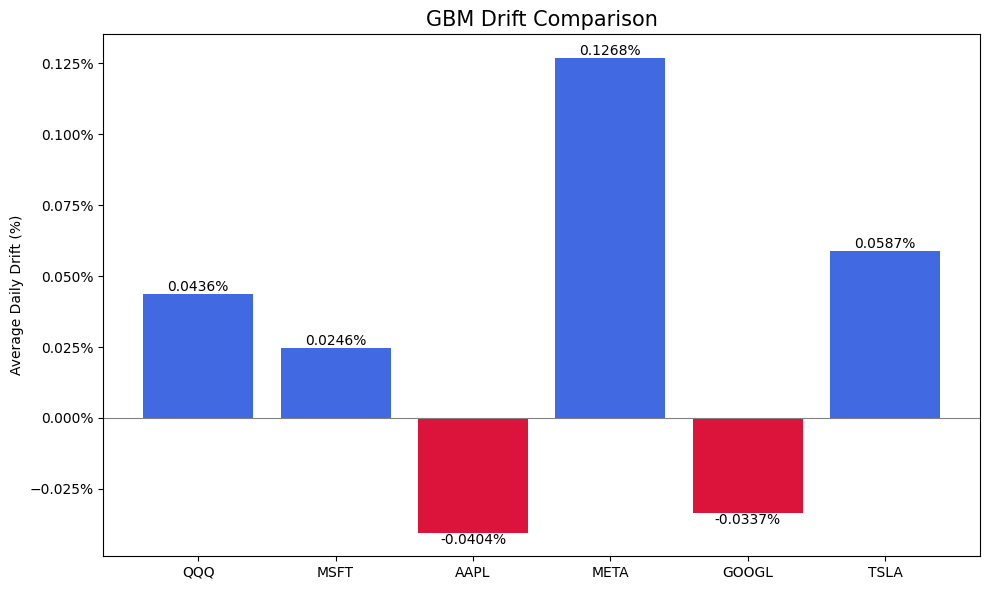

In [ ]:
if __name__ == '__main__':
    plot_gbm_drift()